In [1]:
import os
import shutil
from dataclasses import dataclass, field
from typing import Tuple, List
import numpy as np
import pickle
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import torch
from torch import nn
from torchsummary import summary
import numpy as np
from PIL import Image
from scipy.stats import entropy
from scipy.optimize import curve_fit
from functools import cmp_to_key

import sys
sys.path.append('/home/jurica/Desktop/meta-ood')

from src.dataset.cityscapes import Cityscapes
from src.dataset.lost_and_found import LostAndFound
from config import LAF_ROOT, laf_roots, params
from src.model_utils import inference
from src.imageaugmentations import Compose, Normalize, ToTensor
from src.helper import concatenate_metrics, metrics_to_dataset, components_load

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 13})

In [2]:
def counts_array_to_data_list(counts_array, max_size=None):
    if max_size is None:
        max_size = np.sum(counts_array)  # max of counted array entry
    counts_array = (counts_array / np.sum(counts_array) * max_size).astype("uint32")
    counts_dict = {}
    for i in range(1, len(counts_array) + 1):
        counts_dict[i] = counts_array[i - 1]
    return list(Counter(counts_dict).elements())

def calc_precision_recall(data, balance=False):
    if balance:
        x1 = counts_array_to_data_list(np.array(data["in"]), 1e+5)
        x2 = counts_array_to_data_list(np.array(data["out"]), 1e+5)
    else:
        ratio_in = np.sum(data["in"]) / (np.sum(data["in"]) + np.sum(data["out"]))
        ratio_out = 1 - ratio_in
        x1 = counts_array_to_data_list(np.array(data["in"]), 1e+7 * ratio_in)
        x2 = counts_array_to_data_list(np.array(data["out"]), 1e+7 * ratio_out)
    probas_pred1 = np.array(x1) / 100
    probas_pred2 = np.array(x2) / 100
    y_true = np.concatenate((np.zeros(len(probas_pred1)), np.ones(len(probas_pred2))))
    y_scores = np.concatenate((probas_pred1, probas_pred2))
    return precision_recall_curve(y_true, y_scores) + (average_precision_score(y_true, y_scores), )

def calc_sensitivity_specificity(data, balance=False):
    if balance:
        x1 = counts_array_to_data_list(np.array(data["in"]), max_size=1e+5)
        x2 = counts_array_to_data_list(np.array(data["out"]), max_size=1e+5)
    else:
        x1 = counts_array_to_data_list(np.array(data["in"]))
        x2 = counts_array_to_data_list(np.array(data["out"]))
    probas_pred1 = np.array(x1) / 100
    probas_pred2 = np.array(x2) / 100
    y_true = np.concatenate((np.zeros(len(probas_pred1)), np.ones(len(probas_pred2)))).astype("uint8")
    y_scores = np.concatenate((probas_pred1, probas_pred2))
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return fpr, tpr, thresholds, auc(fpr, tpr)
    
def roc(data):
    fpr, tpr, thresholds = roc_curve(data["y0a"], data["y_pred_proba"][:,1])
    return fpr, tpr, thresholds, auc(fpr, tpr)
    
def pr(data):
    precision, recall, thresholds = precision_recall_curve(data["y0a"], data["y_pred_proba"][:,1])
    return precision, recall, thresholds, auc(recall, precision)

In [3]:
class Stats:
    auroc_pixel_level_list: List[Tuple[float, int]] = [] # (auroc, train_num)
    auprc_pixel_level_list: List[Tuple[float, int]] = [] # (auprc, train_num)
    fpr95_pixel_level_list: List[Tuple[float, int]] = [] # (fpr95, train_num)

    # ROC OoD training
    # (fpr, tpr, tresholds, auroc, train_num)
    roc_pixel_level_list: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_roc_pixel_level: Tuple[List[float], List[float], List[float], float] = 0.0

    # PRC OoD training
    # (precision, recall, tresholds, auprc, train_num)
    pr_pixel_level_list: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_pr_pixel_level: Tuple[List[float], List[float], List[float], float] = 0.0
    
    # ROC METACLASSIFIER LOGISTIC REGRESSION
    # (fpr, tpr, tresholds, auroc, train_num)
    roc_meta_list_logistic: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_roc_meta_logistic: Tuple[List[float], List[float], List[float], float] = 0.0

    # PRC METACLASSIFIER LOGISTIC REGRESSION
    # (precision, recall, tresholds, auprc, train_num)
    pr_meta_list_logistic: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_pr_meta_logistic: Tuple[List[float], List[float], List[float], float] = 0.0

    # ROC METACLASSIFIER NN
    # (fpr, tpr, tresholds, auroc, train_num)
    roc_meta_list_nn: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_roc_meta_nn: Tuple[List[float], List[float], List[float], float] = 0.0

    # PRC METACLASSIFIER NN
    # (precision, recall, tresholds, auprc, train_num)
    pr_meta_list_nn: List[Tuple[List[float], List[float], List[float], float, int]] = []
    mean_pr_meta_nn: Tuple[List[float], List[float], List[float], float] = 0.0
    
    def __init__(self, path):
        self.path = path
        self.get_stats()
    
    def get_stats(self):
        for root, dirs, files in os.walk(f"{self.path}"):
            if f"{self.path}/logs" in root:
                train_num = None
                try:
                    train_num = int(root.split("/")[-1])
                except:
                    continue
    
                for file in files:
                    if file == "meta_classifier_predictions_logistic.p":
                        with open(os.path.join(os.path.abspath(''), f"{self.path}/logs", str(train_num), file), "rb") as f:
                            data = pickle.load(f)
                            fpr, tpr, thresholds, auroc = roc(data)
                            precision, recall, thresholds, auprc = pr(data)
                            self.roc_meta_list_logistic.append((fpr, tpr, thresholds, auroc, train_num))
                            self.pr_meta_list_logistic.append((precision, recall, thresholds, auprc, train_num))
                    
                    if file == "meta_classifier_predictions_nn.p":
                        with open(os.path.join(os.path.abspath(''), f"{self.path}/logs", str(train_num), file), "rb") as f:
                            data = pickle.load(f)
                            fpr, tpr, thresholds, auroc = roc(data)
                            precision, recall, thresholds, auprc = pr(data)
                            self.roc_meta_list_nn.append((fpr, tpr, thresholds, auroc, train_num))
                            self.pr_meta_list_nn.append((precision, recall, thresholds, auprc, train_num))                    
                    
                    if file == "epoch_4_alpha_0.9.p": # in and out pixel counts
                        with open(os.path.join(os.path.abspath(''), f"{self.path}/logs", str(train_num), file), "rb") as f:
                            data = pickle.load(f)
                            fpr, tpr, tresholds, auroc = calc_sensitivity_specificity(data, balance=True)
                            fpr95 = fpr[(np.abs(tpr - 0.95)).argmin()]
                            precision, recall, thresholds, auprc = calc_precision_recall(data)
                            self.roc_pixel_level_list.append((fpr, tpr, thresholds, auroc, train_num))
                            self.pr_pixel_level_list.append((precision, recall, thresholds, auprc, train_num))
                    
                    if file == "pixel_evaluation.txt":
                        with open(os.path.join(os.path.abspath(''), f"{self.path}/logs", str(train_num), file), "r") as f:
                            lines = [line.rstrip() for line in f]
                            
                            for l in lines:
                                if "AUROC" in l:
                                    self.auroc_pixel_level_list.append((float(l.split(" ")[-1]), train_num))
                                elif "AUPRC" in l:
                                    self.auprc_pixel_level_list.append((float(l.split(" ")[-1]), train_num))
                                elif "FPR95" in l:
                                    self.fpr95_pixel_level_list.append((float(l.split(" ")[-1]), train_num))                    

In [7]:
#fs_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/logs_baseline/fs_eval")
#fs_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_less_than_0.2/fs_eval")
#fs_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_greater_than_0.8/fs_eval")

laf_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/logs_baseline/laf_eval")
#laf_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_less_than_0.2/laf_eval")
#laf_stats = Stats("/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_greater_than_0.8/laf_eval")

In [16]:
vv = sorted(laf_stats.fpr95_pixel_level_list, key=lambda x: x[1])
pp = sorted(laf_stats.auprc_pixel_level_list, key=lambda x: x[1])

for i in range(len(vv)-10):
    print(np.mean([x[0] for x in vv[i:i+10]]), np.mean([x[0] for x in pp[i:i+10]]))

0.46893888710557274 0.5693582352444839
0.4464221435376096 0.5714936849806469
0.42778333232710314 0.5851891126080297
0.42482739940307185 0.593565269399991
0.4343158838608018 0.5855046909903909
0.41307945350519104 0.5945861044306586
0.3909087309759478 0.6072446011074358
0.35880972171291864 0.6301234855968066
0.39225115373893754 0.6172023530831858
0.3727663085658083 0.6193822055430506
0.3504259973851226 0.6194076789692987
0.34308503239878513 0.6215108343635247
0.3318995293786279 0.6353454827127267
0.31361709782922637 0.6483200571911315
0.30525831272618253 0.6634462019412379
0.3395293596883129 0.6657134385983052
0.35234419039451403 0.6529160316171081
0.37039231276733525 0.6535902796197125
0.3302224054790491 0.6709233968116151
0.3310707826697853 0.679726596842009
0.3123373696267234 0.7025335683011754
0.30144623099404305 0.709355836398381
0.29244409000918997 0.7048904049135908
0.3128410449861732 0.6826452348301764
0.3180769406540244 0.6730609489236198
0.291434987634959 0.6748698001531098
0.2

In [14]:
dataset = LostAndFound("test", LAF_ROOT)
n_dog_images = 0
for target in dataset.annotations:
    img = Image.open(target)
    if np.sum(np.array(img) == 24) > 0 or np.sum(np.array(img) == 25) > 0:
        n_dog_images += 1
print(n_dog_images)
print(n_dog_images/len(dataset.images))

180
0.14962593516209477


In [ ]:
def get_pr_curve_baseline(i):
    with open(f"/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/logs_baseline/laf_eval/logs/{i}/meta_classifier_predictions_nn.p", "rb") as t:
        data = pickle.load(t)
    return np.sum(np.array(data["y0a"]) == 1)/len(data["y0a"])
    
max_diff_pr_curve = 0.0
max_diff_train_num_pr_curve = None
max_diff_train_num_pr_curve_i = None

max_diff_roc_curve = 0.0
max_diff_train_num_roc_curve = None
max_diff_train_num_roc_curve_i = None

final_index = None

i = 0
for logistic, nn in zip(laf_stats.pr_meta_list_logistic, laf_stats.pr_meta_list_nn):
    if abs(logistic[3] - nn[3]) > max_diff_pr_curve:
        max_diff_pr_curve = abs(logistic[3] - nn[3])
        max_diff_train_num_pr_curve = logistic[4]
        max_diff_train_num_pr_curve_i = i
    i += 1

i = 0
for logistic, nn in zip(laf_stats.roc_meta_list_logistic, laf_stats.roc_meta_list_nn):
    if abs(logistic[3] - nn[3]) > max_diff_roc_curve:
        max_diff_roc_curve = abs(logistic[3] - nn[3])
        max_diff_train_num_roc_curve = logistic[4]
        max_diff_train_num_roc_curve_i = i
    i += 1

print(max_diff_train_num_pr_curve, max_diff_train_num_roc_curve)

print(max_diff_pr_curve, max_diff_roc_curve)

final_index = max_diff_train_num_pr_curve_i if max(max_diff_pr_curve, max_diff_roc_curve) == max_diff_pr_curve \
                                          else max_diff_train_num_roc_curve_i

pr_curve_baseline = get_pr_curve_baseline(max_diff_train_num_pr_curve)

i = 0
for logistic, nn in zip(laf_stats.pr_meta_list_logistic, laf_stats.pr_meta_list_nn):
    if logistic[4] == 321:
        final_index = i
    i += 1

print(final_index)
print(max_diff_train_num_pr_curve)
print(pr_curve_baseline)
print(laf_stats.pr_meta_list_logistic[final_index][3], laf_stats.pr_meta_list_nn[final_index][3])
print(laf_stats.roc_meta_list_logistic[final_index][3], laf_stats.roc_meta_list_nn[final_index][3])

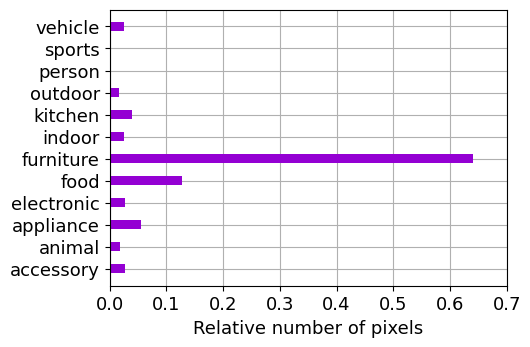

In [78]:
#with open("/home/jurica/Desktop/meta-ood/preparation/coco_pixel_stats.p", "rb") as f:
#    pixel_stats = pickle.load(f)
with open("/home/jurica/Desktop/meta-ood/preparation/modified_stats.p", "rb") as f:
    pixel_stats = pickle.load(f)["greater_than_0.8"]["pixel_stats"]

pixel_stats["person"] = 0
perc_pixel_stats = {}
for x in pixel_stats.keys():
    perc_pixel_stats[x] = pixel_stats[x]/sum(pixel_stats.values())

custom_order_values = [perc_pixel_stats[x] for x in custom_order]

fig, axs = plt.subplots(1, 1, figsize=(5.5,3.665))
axs.set_axisbelow(True)
axs.grid()
axs.set_xlabel("Relative number of pixels")
axs.set_xlim(0.0,0.7)
axs.barh(custom_order, custom_order_values, height=0.4, color=mcolors.CSS4_COLORS["darkviolet"])
fig.tight_layout()
plt.savefig('coco_proxy_pixel_stats_greater_than_0.8.png', bbox_inches='tight')

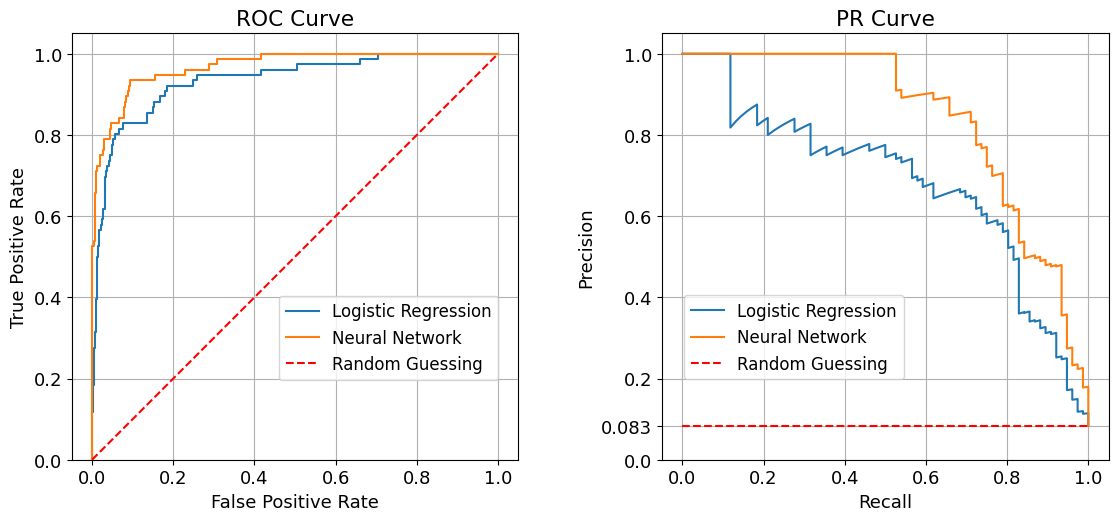

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
fig.tight_layout(h_pad=1)

axs[1].plot(laf_stats.pr_meta_list_logistic[final_index][1], laf_stats.pr_meta_list_logistic[final_index][0], label="Logistic Regression")
axs[1].plot(laf_stats.pr_meta_list_nn[final_index][1], laf_stats.pr_meta_list_nn[final_index][0], label="Neural Network")
axs[1].set_title("PR Curve")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].grid()
axs[1].set_aspect('equal', 'box')

axs[1].plot((0.0, 1.0), (pr_curve_baseline, pr_curve_baseline), '--', color='red', label="Random Guessing")
axs[1].legend(bbox_to_anchor=(0.56, 0.405), ncol=1, prop={'size': 12})
axs[1].set_ylim(0.0, 1.05)

ticks = [0.0, round(pr_curve_baseline, 3), 0.2 ,0.4 ,0.6, 0.8, 1.0]
axs[1].set_yticks(ticks)
axs[1].yaxis.set_ticklabels(ticks)

axs[0].plot(laf_stats.roc_meta_list_logistic[final_index][0], laf_stats.roc_meta_list_logistic[final_index][1], label="Logistic Regression")
axs[0].plot(laf_stats.roc_meta_list_nn[final_index][0], laf_stats.roc_meta_list_nn[final_index][1], label="Neural Network")
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].plot((0.0, 1.0), (0.0, 1.0), '--', color='red', label="Random Guessing")
axs[0].legend(bbox_to_anchor=(0.445, 0.404), ncol=1, prop={'size': 12})
axs[0].grid()
axs[0].set_aspect('equal', 'box')
axs[0].set_ylim(0.0, 1.05)


#plt.savefig('roc_and_pr_meta_classifier_curves.png', bbox_inches='tight')
plt.show()

In [5]:
m_cityscapes_val = []
#cityscapes_path = "/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/logs_baseline/valset_predictions_results"
#cityscapes_path = "/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_less_than_0.2/valset_predictions_results"
cityscapes_path = "/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/logs/coco_greater_than_0.8/valset_predictions_results"

for root, dirs, files in os.walk(cityscapes_path):
    if root.split("/")[-1] == "valset_predictions_results": continue
    train_num = int(root.split("/")[-1])
    
    for file in files:
        if file == "resultPixelLevelSemanticLabeling.json":
            with open(os.path.join(os.path.abspath(''), f"{cityscapes_path}", str(train_num), file), "r") as f:
                data = json.load(f)

                m_cityscapes_val.append(data["averageScoreClasses"])

#m_cityscapes_val += extra_cityscapes

average_m_cityscapes_val = np.mean(m_cityscapes_val)
print(average_m_cityscapes_val)
print(len(m_cityscapes_val))

0.8743518616095882
10


In [6]:
def compare3(x1, x2):
    if x1[0] < x2[0] and x1[1] > x2[1] and x1[2] > x2[2]: return -1
        
    elif x1[0] == x2[0] and x1[1] > x2[1] and x1[2] > x2[2]: return -1
    elif x1[0] < x2[0] and x1[1] == x2[1] and x1[2] > x2[2]: return -1
    elif x1[0] < x2[0] and x1[1] > x2[1] and x1[2] == x2[2]: return -1
    
    elif x1[0] == x2[0] and x1[1] == x2[1] and x1[2] > x2[2]: return -1
    elif x1[0] < x2[0] and x1[1] == x2[1] and x1[2] == x2[2]: return -1 
    elif x1[0] == x2[0] and x1[1] > x2[1] and x1[2] == x2[2]: return -1

    return 0
    
def compare2(x1, x2):
    if x1[0] < x2[0] and x1[1] > x2[1]: return -1
        
    elif x1[0] == x2[0] and x1[1] > x2[1]: return -1
    elif x1[0] < x2[0] and x1[1] == x2[1]: return -1
    elif x1[0] < x2[0] and x1[1] > x2[1]: return -1
    
    elif x1[0] == x2[0] and x1[1] == x2[1]: return -1
    elif x1[0] < x2[0] and x1[1] == x2[1]: return -1 
    elif x1[0] == x2[0] and x1[1] > x2[1]: return -1

    return 0

def get_best(stats_object):
    zipped = [x for x in zip(stats_object.fpr95_pixel_level_list, stats_object.auprc_pixel_level_list, m_cityscapes_val)]
    best = sorted(zipped, key=cmp_to_key(compare2))[0]
    return best

In [7]:
print("BEST METRICS LAF:")
best = get_best(laf_stats)
print(f"FPR95: {round(best[0][0], 2)}")
print(f"AUPRC: {round(best[1][0], 2)}")
print(f"mIoU: {round(best[2], 2)}")

print()
print("AVERAGE METRICS LAF:")
print(f"mFPR95: {round(np.mean([x[0] for x in laf_stats.fpr95_pixel_level_list]), 2)}")
print(f"mAUPRC: {round(np.mean([x[0] for x in laf_stats.auprc_pixel_level_list]), 2)}")
print(f"mmIoU: {round(np.mean(m_cityscapes_val), 2)}")
print()

print("...")
m1 = round(np.min([x[0] for x in laf_stats.fpr95_pixel_level_list]), 2)
m2 = round(np.max([x[0] for x in laf_stats.auprc_pixel_level_list]), 2)
m3 = round(np.max(m_cityscapes_val), 2)
print(m1, m2, m3)

BEST METRICS LAF:
FPR95: 0.13
AUPRC: 0.48
mIoU: 0.87

AVERAGE METRICS LAF:
mFPR95: 0.44
mAUPRC: 0.44
mmIoU: 0.87

...
0.13 0.53 0.88


In [7]:
print("BEST METRICS FS:")
best = get_best(fs_stats)
print(f"FPR95: {round(best[0][0], 2)}")
print(f"AUPRC: {round(best[1][0], 2)}")
print(f"mIoU: {round(best[2], 2)}")

print()
print("AVERAGE METRICS FS:")
print(f"mFPR95: {round(np.mean([x[0] for x in fs_stats.fpr95_pixel_level_list]), 2)}")
print(f"mAUPRC: {round(np.mean([x[0] for x in fs_stats.auprc_pixel_level_list]), 2)}")
print(f"mmIoU: {round(np.mean(m_cityscapes_val), 2)}")
print()

print("...")
m1 = round(np.min([x[0] for x in fs_stats.fpr95_pixel_level_list]), 2)
m2 = round(np.max([x[0] for x in fs_stats.auprc_pixel_level_list]), 2)
m3 = round(np.max(m_cityscapes_val), 2)
print(m1, m2, m3)

BEST METRICS FS:
FPR95: 0.31
AUPRC: 0.25
mIoU: 0.88

AVERAGE METRICS FS:
mFPR95: 0.65
mAUPRC: 0.2
mmIoU: 0.87

...
0.31 0.31 0.88


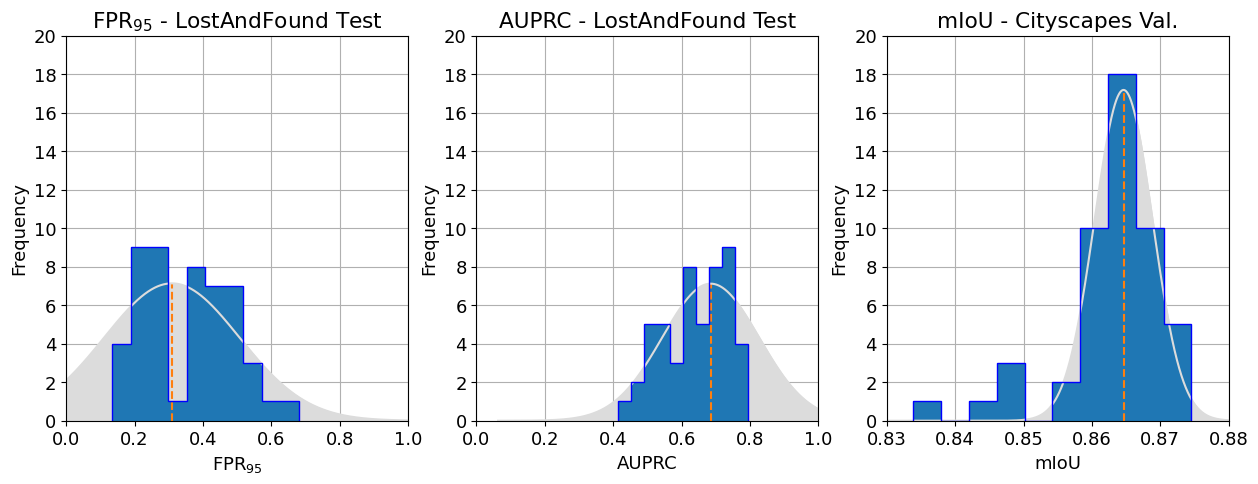

In [20]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

def compute_histogram(values, _range):
    hist, bin_edges = np.histogram(values)
    
    bins_mean = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    
    bin_widths = np.diff(bin_edges)
    bin_centers = bins_mean
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[1., 0., 1.])
    
    x_interval_for_fit = np.linspace(bin_edges[0]+_range[0], bin_edges[-1]+_range[1], 10000)
    
    return bin_edges, bins_mean, hist, x_interval_for_fit, gaussian(x_interval_for_fit, *popt)

def compute_pixel_level_metrics_distributions(stats_object):
    title = ["$\mathregular{FPR_{95}}$ - LostAndFound Test", "AUPRC - LostAndFound Test", "mIoU - Cityscapes Val."]
    xlabel = ["$\mathregular{FPR_{95}}$", "AUPRC", "mIoU"]
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    #fig, axs = plt.subplots(1, 1, figsize=(3.4191176470588234,3.8500000000000005))
    for i, metric in enumerate([[x[0] for x in stats_object.fpr95_pixel_level_list], 
                    [x[0] for x in stats_object.auprc_pixel_level_list], m_cityscapes_val]):
        _range = [-0.35, 0.35] if i != 2 else [-0.01, 0.01]
        bin_edges, bins_mean, hist, x_interval_for_fit, gaussian_fit = compute_histogram(metric, _range)
        
        mean_x_coord = x_interval_for_fit[np.where(gaussian_fit == np.max(gaussian_fit))[0][0]]
        mean_y_coord = np.max(gaussian_fit)

        x_i = np.array([i for i, x in enumerate(x_interval_for_fit) if x >= 0.0 and x <= 1.0])
        x_plot = np.array([x for i, x in enumerate(x_interval_for_fit) if x >= 0.0 and x <= 1.0])
        g_fit = np.array([g for i, g in enumerate(gaussian_fit) if i in x_i])
        
        axs[i].set_title(title[i])
        axs[i].set_xlabel(xlabel[i])
        axs[i].set_ylabel("Frequency")
        axs[i].plot((mean_x_coord, mean_x_coord), (0.0, mean_y_coord), '--', color=mcolors.TABLEAU_COLORS["tab:orange"])#color='#FF8C00')
        axs[i].plot(x_plot, g_fit, label='fit', c=mcolors.CSS4_COLORS["gainsboro"])

        axs[i].fill_between(x_plot, g_fit, color=mcolors.CSS4_COLORS["gainsboro"])
        #axs[i].scatter(bins_mean, hist, s=15)
        #axs[i].hist(metric, color=mcolors.CSS4_COLORS["navy"])#, histtype='step')
        axs[i].hist(metric, color=mcolors.TABLEAU_COLORS["tab:blue"])
        axs[i].hist(metric, color='blue', histtype='step')
        axs[i].grid()
        if i != 2: axs[i].set_xlim(0.0, 1.0)
        else: axs[i].set_xlim(0.83, 0.88)
        #axs[i].set_ylim(0, 20)

        axs[i].set_yticks(list(range(0, 22, 2)))
        axs[i].set_axisbelow(True)

    #fig.tight_layout()
    plt.savefig(f"/home/jurica/Desktop/histograms_laf.png", bbox_inches='tight')        
compute_pixel_level_metrics_distributions(laf_stats)

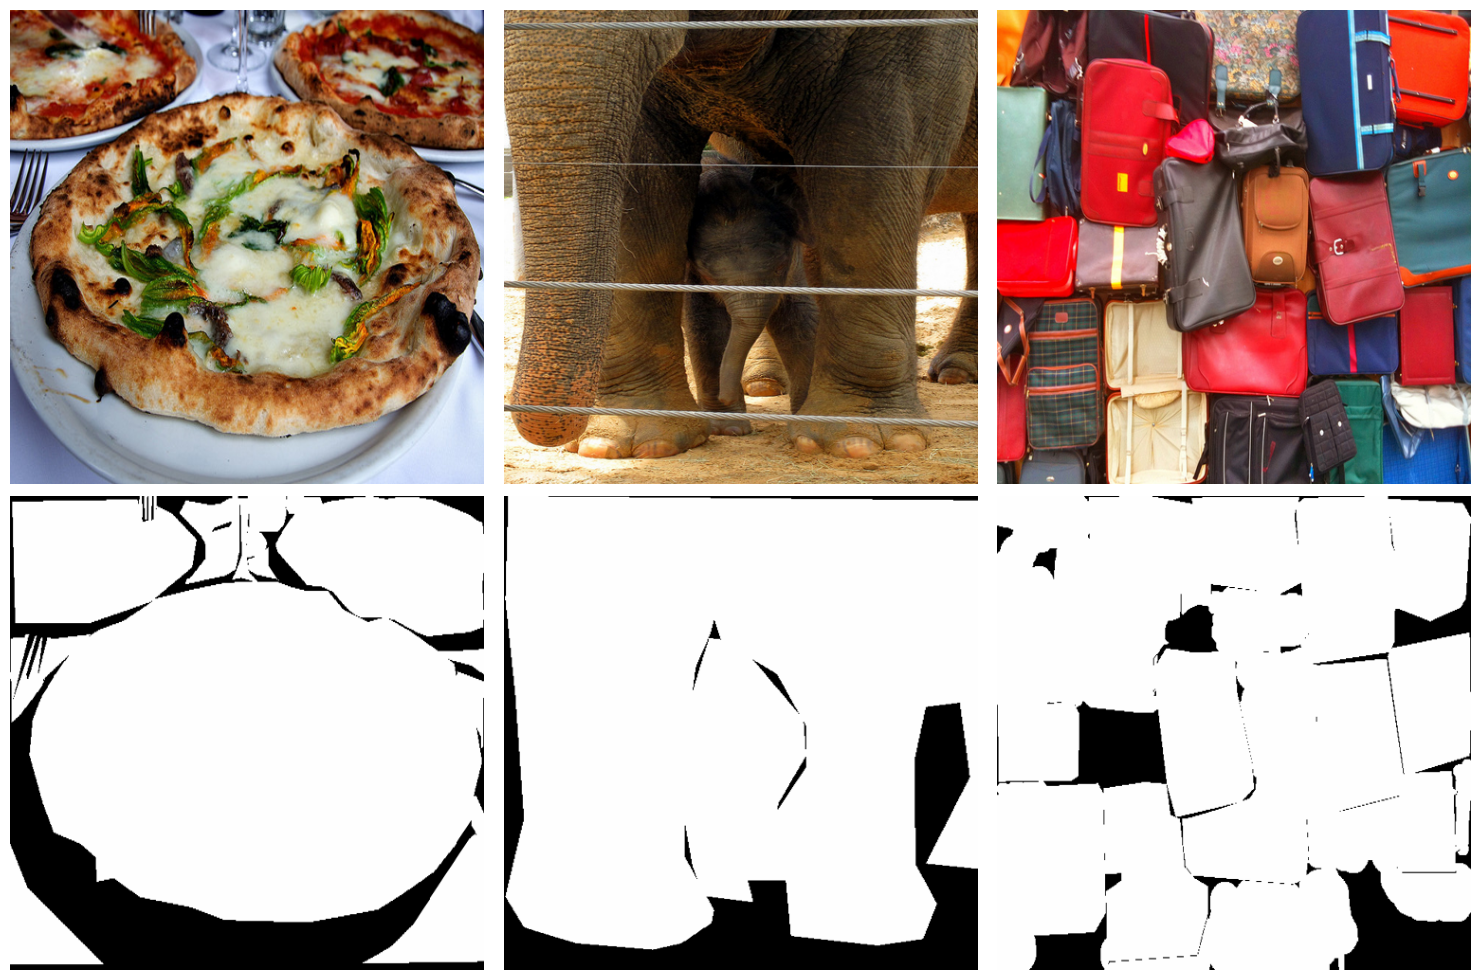

In [41]:
path_to_coco = "/home/jurica/Desktop/meta-ood/datasets/COCO/2017/train2017"
path_to_coco_masks_high_quality = "/home/jurica/Desktop/meta-ood/datasets/COCO/2017/annotations/less_than_0.2"
path_to_coco_masks_low_quality = "/home/jurica/Desktop/meta-ood/datasets/COCO/2017/annotations/greater_than_0.8"

high_quality_imgs = ["000000028508", "000000473555", "000000138397"]
low_quality_imgs = ["000000042785", "000000179261", "000000278899"]

def plot_imgs_and_masks(imgs, high_quality=False):
    if high_quality:
        path_to_masks = path_to_coco_masks_high_quality
    else:
        path_to_masks = path_to_coco_masks_low_quality
        
    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    for i, _img in enumerate(imgs):
        img = Image.open(os.path.join(path_to_coco, _img+".jpg")).convert("RGB").resize((500, 500))
        mask = Image.open(os.path.join(path_to_masks, _img+".png")).convert("RGB").resize((500, 500))
        axs[0][i].imshow(img)
        axs[0][i].axis("off")

        axs[1][i].imshow(mask)
        axs[1][i].axis("off")
        
    fig.tight_layout()
    plt.savefig(f"/home/jurica/Desktop/{'high_quality' if high_quality else 'low_quality'}_proxy_ood_images.png", bbox_inches='tight')   

#plot_imgs_and_masks(high_quality_imgs, high_quality=True)
plot_imgs_and_masks(low_quality_imgs, high_quality=False)

In [2]:
roots = laf_roots()
p = params()
transform = Compose([ToTensor(), Normalize(Cityscapes.mean, Cityscapes.std)])
dataset = LostAndFound("test", LAF_ROOT, transform=transform)
inf = inference(params, roots, dataset, dataset.num_eval_classes)

Checkpoint file: /media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/checkpoints/DeepLabV3+_WideResNet38_epoch_4_alpha_0.9.pth
Load model: DeepLabV3+_WideResNet38... ok


In [3]:
def entropy_segments_mask(probs, t):
    ent = entropy(probs) / np.log(probs.shape[0])
    ent[ent < t] = 0
    ent[ent >= t] = 255
    return Image.fromarray(ent.astype("uint8"))


def mark_ROI_on_original_image(img_path, img=None):
    if img is None:
        img = Image.open(img_path).convert("RGBA")
    else:
        img = img.convert("RGBA")

    gt = img_path.split("_")
    gt[-1] = "gtCoarse_color.png"
    gt = "_".join(gt)
    gt = gt.split("leftImg8bit")
    gt = "gtCoarse".join(gt)
    gt = Image.open(gt).convert("RGB")


    # Create a copy of the layer
    overlay = img.copy().convert("RGBA")

    width, height = gt.size
    
    for x in range(width):
        for y in range(height):
            if gt.getpixel((x,y)) != (0, 0, 142) and gt.getpixel((x,y)) != (128, 64, 128):
                continue
                #save_gt.putpixel((x,y), (255,255,255,255))
            else:
                if gt.getpixel((x,y)) == (128, 64, 128):
                    overlay.putpixel((x,y), (0, 255, 0, 255))
                elif gt.getpixel((x,y)) == (0, 0, 142):
                    overlay.putpixel((x,y), (255, 0, 0, 255))
                #elif gt.getpixel((x,y)) == (0,0,0):
                #    save_gt.putpixel((x,y), (255, 255, 255, 255))

    overlay.putalpha(55)

    return Image.alpha_composite(img, overlay)


def mark_anomaly_on_original_image(img_path, gt_path=None, predicted_mask=None, mask_is_entropy_mask=False, 
                                   mask_is_component=False, img_with_ROI=False):
    if gt_path is None:
        gt = img_path.split("_")
        gt[-1] = "gtCoarse_color.png"
        gt = "_".join(gt)
        gt = gt.split("leftImg8bit")
        gt = "gtCoarse".join(gt)
        gt = Image.open(gt).convert("RGB")
    else:
        gt = Image.open(gt_path).convert("RGB")
    
    width, height = gt.size
    img = Image.open(img_path)
    
    for x in range(width):
        for y in range(height):
            if predicted_mask is None:
                if gt.getpixel((x,y)) == (0, 0, 142):
                    img.putpixel((x,y), (255, 0, 0))
            else:    
                if mask_is_entropy_mask is True:
                    if (gt.getpixel((x,y)) == (0, 0, 142) and predicted_mask.getpixel((x,y)) == 255) or \
                       (gt.getpixel((x,y)) == (128, 64, 128) and predicted_mask.getpixel((x,y)) == 255):
                            img.putpixel((x,y), (255, 0, 0))
            
                elif mask_is_component is True:
                    if predicted_mask.getpixel((x,y)) > 0:
                        img.putpixel((x,y), (255, 0, 0))
                else:
                    if predicted_mask.getpixel((x,y)) == 255:
                        img.putpixel((x,y), (255, 0, 0))
    return img


def remove(meta_path, i, metaseg_dir, load_subdir):
    with open(meta_path, "rb") as metrics_file:
        print(meta_path)
        metrics = pickle.load(metrics_file)
        K = metrics["kick"]
        start = metrics["start"]
        
    comp_pred = abs(components_load(i, metaseg_dir, load_subdir))

    comp_pred_img = Image.fromarray(comp_pred)

    comp_pred = comp_pred.flatten()

    removed = []
    for l, k in enumerate(K[start[i]:start[i + 1]]):
        if k == 1:
            #print(f"{i}, removing", np.sum(comp_pred == l+1))
            removed.append((i,np.sum(comp_pred == l+1)))
            comp_pred[comp_pred == l + 1] = 0

    comp_pred[comp_pred > 0] = 1

    comp_pred_img_removed_fp = Image.fromarray(comp_pred.reshape(1024, 2048))

    return comp_pred_img, comp_pred_img_removed_fp, removed

In [4]:
for i in range(len(dataset)):
    pass
    # 984
    #if dataset.images[i] == "/home/jurica/Desktop/meta-ood/datasets/lost_and_found/leftImg8bit/test/04_Maurener_Weg_8/04_Maurener_Weg_8_000005_000170_leftImg8bit.png":
    #    print(i)
    
    # 606
    #if dataset.images[i] == "/home/jurica/Desktop/meta-ood/datasets/lost_and_found/leftImg8bit/test/07_Festplatz_Flugfeld/07_Festplatz_Flugfeld_000002_000390_leftImg8bit.png":
    #    print(i)

load_path = f"/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED"
nn_meta_path = f"{load_path}/meta_classified_nn.p"
logistic_meta_path = f"{load_path}/meta_classified_logistic.p"
metaseg_dir = "/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/metaseg_io"
load_subdir = "epoch_4_alpha_0.9_t0.7"
num_imgs = 1203

removed_logistic = []
removed_nn = []

for i in range(len(dataset)):
    comp_pred_img, comp_pred_img_removed_fp, removed = remove(logistic_meta_path, i, metaseg_dir, load_subdir)
    for r in removed:
        removed_logistic.append(r)
    
    comp_pred_img, comp_pred_img_removed_fp, removed = remove(nn_meta_path, i, metaseg_dir, load_subdir)
    for r in removed:
        removed_nn.append(r)

/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_nn.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_nn.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_nn.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-

In [5]:
print([x for x in removed_logistic if x not in removed_nn])
print()
print([x for x in removed_nn if x not in removed_logistic])
print()
print([x for x in removed_nn if x in removed_logistic])

[(195, 1), (338, 305), (409, 15), (425, 8), (425, 66), (493, 12), (518, 406), (535, 8), (552, 431), (658, 4), (666, 5), (698, 73), (981, 6), (981, 3), (1131, 13)]

[(11, 12), (15, 4), (21, 4), (22, 2), (22, 6), (46, 1), (62, 3), (77, 2), (113, 1), (114, 4), (128, 25), (154, 25), (160, 44), (193, 23), (275, 14), (322, 51), (405, 1983), (425, 10), (433, 15), (533, 105), (614, 8), (618, 26), (667, 24), (729, 13), (775, 674), (787, 447), (787, 192), (831, 22), (941, 2), (956, 1), (984, 86), (984, 35), (994, 734)]

[(15, 1), (15, 8), (15, 1), (16, 2), (16, 5), (16, 18), (16, 17), (22, 34), (46, 2), (49, 1), (49, 1), (62, 6), (62, 6), (62, 2), (62, 11), (78, 3), (79, 10), (79, 8), (79, 2), (81, 1), (92, 5), (109, 7), (109, 3), (109, 2), (117, 14), (117, 4), (125, 2), (125, 13), (125, 12), (125, 2), (126, 7), (145, 55), (218, 150), (218, 265), (222, 6), (282, 8), (302, 8), (322, 1), (322, 4), (338, 3), (372, 185), (409, 10), (409, 70), (409, 178), (409, 161), (425, 5), (485, 3), (493, 24), (4

/home/jurica/Desktop/meta-ood/datasets/lost_and_found/leftImg8bit/test/07_Festplatz_Flugfeld/07_Festplatz_Flugfeld_000004_000190_leftImg8bit.png
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_logistic.p
/media/jurica/c2d76687-c280-496a-91dc-acee1afa83ab1/io/DeepLabV3+_WideResNet38/laf_eval/logs/BASELINE_REPRODUCED/meta_classified_nn.p


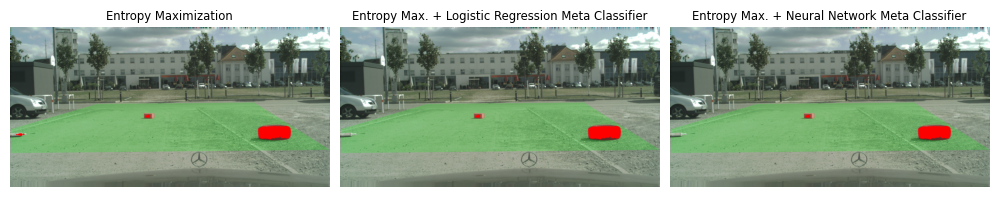

In [90]:
def create_output_image(inf, i):
    print(dataset.images[i])
        
    
    probs, gt_train, gt_label, im_path = inf.probs_gt_load(i)
    entropy_mask = entropy_segments_mask(probs, 0.7)

    c0 = mark_ROI_on_original_image(im_path)
    
    comp_pred_img, comp_pred_img_removed_fp, _ = remove(logistic_meta_path, i, metaseg_dir, load_subdir)
    
    c2 = mark_anomaly_on_original_image(im_path, predicted_mask=comp_pred_img, mask_is_component=True)
    c2 = mark_ROI_on_original_image(im_path, c2)

    comp_pred_img, comp_pred_img_removed_fp, _ = remove(logistic_meta_path, i, metaseg_dir, load_subdir)
    
    c3 = mark_anomaly_on_original_image(im_path, predicted_mask=comp_pred_img_removed_fp, mask_is_component=True)
    c3 = mark_ROI_on_original_image(im_path, c3)
    
    comp_pred_img, comp_pred_img_removed_fp, _ = remove(nn_meta_path, i, metaseg_dir, load_subdir)
    
    c4 = mark_anomaly_on_original_image(im_path, predicted_mask=comp_pred_img_removed_fp, mask_is_component=True)
    c4 = mark_ROI_on_original_image(im_path, c4)    
    
    plt.rcParams.update({'font.size': 7})
    fig, axs = plt.subplots(1, 3, figsize = (10, 10))
    
    #axs[0].imshow(np.array(c0))
    axs[0].imshow(np.array(c2))
    axs[1].imshow(np.array(c3)) # for logistic metaclassifier
    axs[2].imshow(np.array(c4)) # for NN metaclassifier

    #axs[0].set_axis_off()
    axs[0].set_axis_off()
    axs[0].set_title("Entropy Maximization")
    axs[1].set_axis_off()
    axs[1].set_title("Entropy Max. + Logistic Regression Meta Classifier")
    axs[2].set_axis_off()
    axs[2].set_title("Entropy Max. + Neural Network Meta Classifier")
    fig.tight_layout()

    plt.savefig(f"/home/jurica/Downloads/in_favor_neural_network_{i}.png", bbox_inches='tight')

create_output_image(inf, 535)

In [91]:
model = nn.Sequential(
    nn.Linear(75, 75),
    nn.ReLU(),

    nn.Linear(75, 75),
    nn.ReLU(),
    
    nn.Linear(75, 75),
    nn.ReLU(),

    nn.Linear(75, 1),
    nn.Sigmoid()
)
summary(model.cuda(), (1, 75), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 75]           5,700
              ReLU-2                 [1, 1, 75]               0
            Linear-3                 [1, 1, 75]           5,700
              ReLU-4                 [1, 1, 75]               0
            Linear-5                 [1, 1, 75]           5,700
              ReLU-6                 [1, 1, 75]               0
            Linear-7                  [1, 1, 1]              76
           Sigmoid-8                  [1, 1, 1]               0
Total params: 17,176
Trainable params: 17,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------
